# Mechanical Components Classification Model

## Load images in train and validatino datasets

In [1]:
import os

import keras
import matplotlib.pyplot as plt
import tensorflow as tf

"""
define dataset directory address with classes grouped in subdirectories following the structure

main_directory/
...class_a/
......a_image_1.jpg
......a_image_2.jpg
...class_b/
......b_image_1.jpg
......b_image_2.jpg
"""

# data_dir = './data/MCB_A_images_64/train'
data_dir = '/home/leofernanndes/tcc/data/MCB_A_images_64/train'
img_height, img_width = 64, 64
batch_size = 128

# in this case, we're going to use train directory to train and validation leaving test completely isolated for testing purposes
train_ds, val_ds = keras.utils.image_dataset_from_directory(
    data_dir,
    labels='inferred',
    validation_split=0.2,
    subset="both",
    seed=123,
    image_size=(img_height, img_width),
    shuffle=True,
    batch_size=batch_size,
    class_names=os.listdir(data_dir),
    color_mode='rgb'
)

AUTOTUNE = tf.data.AUTOTUNE
train_ds = train_ds.cache().prefetch(buffer_size=AUTOTUNE)
val_ds = val_ds.cache().prefetch(buffer_size=AUTOTUNE)

2024-09-07 11:05:48.162571: I tensorflow/core/util/port.cc:153] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2024-09-07 11:05:48.332770: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:485] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-09-07 11:05:48.411894: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:8454] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-09-07 11:05:48.437539: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1452] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-09-07 11:05:48.562927: I tensorflow/core/platform/cpu_feature_guar

Found 563736 files belonging to 68 classes.
Using 450989 files for training.
Using 112747 files for validation.


I0000 00:00:1725717965.826889    9264 cuda_executor.cc:1015] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
I0000 00:00:1725717965.903461    9264 cuda_executor.cc:1015] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
I0000 00:00:1725717965.906742    9264 cuda_executor.cc:1015] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
I0000 00:00:1725717965.912969    9264 cuda_executor.cc:1015] successful NUMA node read from SysFS ha

2024-09-07 11:06:57.210784: W tensorflow/core/kernels/data/cache_dataset_ops.cc:913] The calling iterator did not fully read the dataset being cached. In order to avoid unexpected truncation of the dataset, the partially cached contents of the dataset  will be discarded. This can happen if you have an input pipeline similar to `dataset.cache().take(k).repeat()`. You should use `dataset.take(k).cache().repeat()` instead.
2024-09-07 11:06:57.254969: I tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


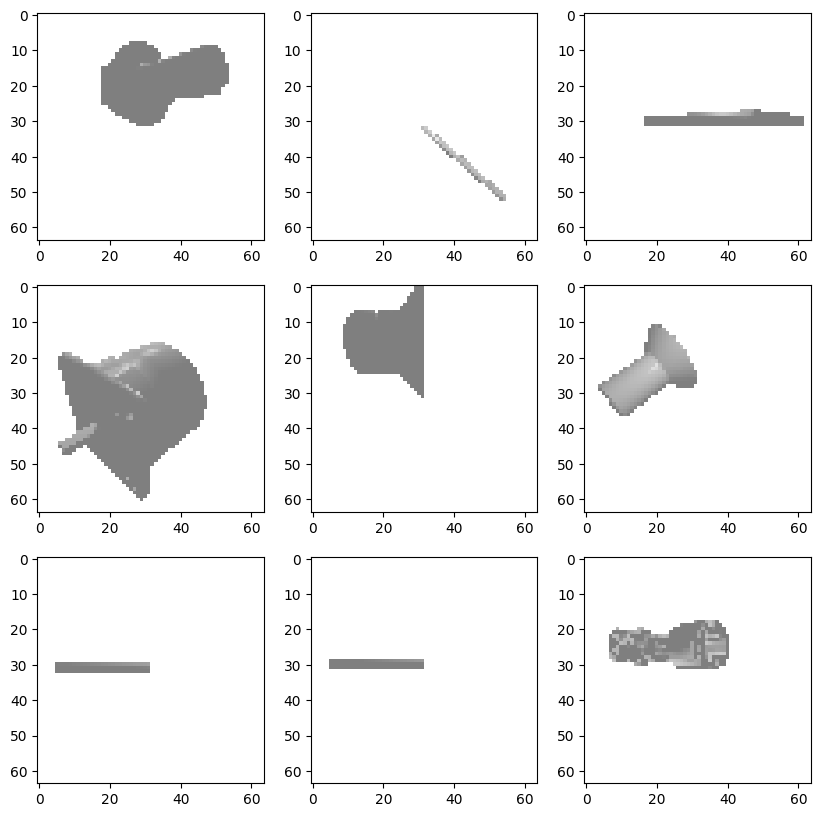

In [2]:
plt.figure(figsize=(10, 10))
for images, labels in train_ds.take(1):
    for i in range(9):
        ax = plt.subplot(3, 3, i + 1)
        plt.imshow(images[i].numpy().astype("uint8"))
plt.show()

## Model training

In [3]:
# considering the models can easily take more than 12h to converge it is a good practice to keep tracking of training steps to recover from any unexpected break
# `checkpoint_filepath` are going to be used below in a callback responsible to always save the best performing step of the training phase
checkpoint_filepath = './model1.keras'

# defining a keras resnet152 pretrained in imagenet dataset to leverage transfer learning
conv_model = keras.applications.ResNet152(weights='imagenet', include_top=False, input_shape=(64, 64, 3), classes=len(os.listdir(f'{data_dir}')))

# flatten the output of the convolutional part:
x = keras.layers.Flatten()(conv_model.output)
# three hidden layers
x = keras.layers.Dense(1024, activation='relu')(x)
x = keras.layers.Dropout(rate=0.2)(x)
x = keras.layers.Dense(400, activation='relu')(x)
x = keras.layers.Dropout(rate=0.2)(x)
x = keras.layers.Dense(136, activation='relu')(x)
x = keras.layers.Dropout(rate=0.2)(x)
# final softmax must have 1 neuron for each class on training data
predictions = keras.layers.Dense(len(os.listdir(f'{data_dir}')), activation='softmax')(x)

# creating the full model:
model1 = keras.models.Model(inputs=conv_model.input, outputs=predictions)

# ensuring every resnet layer is frozen not to be retrained on our data
# in this model we just want the three layers that come after the resnet to be trainable
for layer in conv_model.layers:
    layer.trainable = False

model1.compile(
    loss=keras.losses.SparseCategoricalCrossentropy(from_logits=True),
    optimizer=keras.optimizers.Adamax(),
    metrics=['accuracy']
)

model_checkpoint_callback = keras.callbacks.ModelCheckpoint(
    filepath=checkpoint_filepath,
    save_weights_only=False,
    monitor='val_accuracy',
    mode='max',
    save_best_only=True)

# training the model with 2 epochs just for checking everithing is right
# in order to converge, this particular combination of data and model should take at least 220 epochs
early_stopping_callback = keras.callbacks.EarlyStopping(monitor='val_acc', patience=20, mode='max')
history = model1.fit(train_ds, validation_data=val_ds, epochs=2, callbacks=[early_stopping_callback, model_checkpoint_callback])

Epoch 1/2


/home/leofernanndes/dev/mestrado/mechanical-components/venv/lib/python3.10/site-packages/keras/src/backend/tensorflow/nn.py:609: UserWarning: "`sparse_categorical_crossentropy` received `from_logits=True`, but the `output` argument was produced by a Softmax activation and thus does not represent logits. Was this intended?
  output, from_logits = _get_logits(
I0000 00:00:1725718032.867693    9475 service.cc:146] XLA service 0x7841ac0025f0 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1725718032.867707    9475 service.cc:154]   StreamExecutor device (0): NVIDIA GeForce RTX 3070, Compute Capability 8.6
2024-09-07 11:07:13.155879: I tensorflow/compiler/mlir/tensorflow/utils/dump_mlir_util.cc:268] disabling MLIR crash reproducer, set env var `MLIR_CRASH_REPRODUCER_DIRECTORY` to enable.
2024-09-07 11:07:14.381603: I external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:531] Loaded cuDNN version 8907
2024-09-07 11:07:15.115924: I externa

   3/3524 ━━━━━━━━━━━━━━━━━━━━ 2:21 40ms/step - accuracy: 0.0373 - loss: 5.2090  

I0000 00:00:1725718037.309968    9475 device_compiler.h:188] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


3522/3524 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step - accuracy: 0.4216 - loss: 2.1116

2024-09-07 11:09:41.702065: I external/local_xla/xla/stream_executor/cuda/cuda_asm_compiler.cc:393] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_17572', 120 bytes spill stores, 120 bytes spill loads

2024-09-07 11:09:41.748930: I external/local_xla/xla/stream_executor/cuda/cuda_asm_compiler.cc:393] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_17572', 64 bytes spill stores, 64 bytes spill loads



3524/3524 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step - accuracy: 0.4217 - loss: 2.1114

2024-09-07 11:09:46.777947: I external/local_xla/xla/stream_executor/cuda/cuda_asm_compiler.cc:393] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_4889', 132 bytes spill stores, 132 bytes spill loads

2024-09-07 11:09:46.804379: I external/local_xla/xla/stream_executor/cuda/cuda_asm_compiler.cc:393] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_4889', 348 bytes spill stores, 296 bytes spill loads

2024-09-07 11:09:46.887202: I external/local_xla/xla/stream_executor/cuda/cuda_asm_compiler.cc:393] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_4896', 320 bytes spill stores, 320 bytes spill loads

2024-09-07 11:10:19.499385: I external/local_xla/xla/stream_executor/cuda/cuda_asm_compiler.cc:393] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_4889', 12 bytes spill stores, 12 bytes spill loads

2024-09-07 11:10:19.754757: I external/local_xla/xla/s

3524/3524 ━━━━━━━━━━━━━━━━━━━━ 195s 53ms/step - accuracy: 0.4217 - loss: 2.1113 - val_accuracy: 0.6423 - val_loss: 1.1830
Epoch 2/2
3524/3524 ━━━━━━━━━━━━━━━━━━━━ 167s 47ms/step - accuracy: 0.6195 - loss: 1.2593 - val_accuracy: 0.6903 - val_loss: 1.0018


## Model loading

In [4]:
# loading a trained model to continue training or to perform predictions on unseen data
model_path = './model1.keras'
second_model = keras.models.load_model(model_path)

model_checkpoint_callback = keras.callbacks.ModelCheckpoint(
    filepath=checkpoint_filepath,
    save_weights_only=False,
    monitor='val_accuracy',
    mode='max',
    save_best_only=True)

early_stopping_callback = keras.callbacks.EarlyStopping(monitor='val_acc', patience=20, mode='max')
history2 = second_model.fit(train_ds, validation_data=val_ds, epochs=2, callbacks=[early_stopping_callback, model_checkpoint_callback])

Epoch 1/2
3524/3524 ━━━━━━━━━━━━━━━━━━━━ 192s 52ms/step - accuracy: 0.6706 - loss: 1.0745 - val_accuracy: 0.7166 - val_loss: 0.9081
Epoch 2/2
3524/3524 ━━━━━━━━━━━━━━━━━━━━ 179s 51ms/step - accuracy: 0.6993 - loss: 0.9716 - val_accuracy: 0.7339 - val_loss: 0.8483
